# Cascading Bandits実装

WIP...

In [2]:
import math
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import bernoulli

/Users/hiromu.nakamura/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [37]:
np.random.seed(0)

In [38]:
class CascadingModelEnv():
	def __init__(self, E: list[float]):
		self.E = E

	def click(self, A: list[int]) -> int:
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				return i+1
		return -1
	
	def opt(self, k: int) -> list[int]:
		return sorted(range(len(self.E)), key=lambda i: self.E[i], reverse=True)[:k]

[3, 2]


(array([495.,   0.,   0.,   0.,   0., 104.,   0., 171.,   0., 230.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <BarContainer object of 10 artists>)

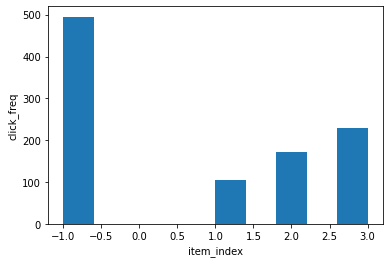

In [39]:
## test
E = [0, 0.1, 0.2, 0.3]
env = CascadingModelEnv(E)

results = []
for i in range(1000):
	results.append(env.click([1,2,3]))

print(env.opt(k=2))

plt.xlabel("item_index")
plt.ylabel("click_freq")
plt.hist(results)

In [40]:
class CascadeUCBAgent(object):
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int):
    return self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e])

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.is_click(click, i+1) ) / self.counts[e]

In [63]:
## debug

# E = [0.4, 0.2, 0.2, 0.1, 0.1, 0.3, 0.2, 0.1, 0.3, 0.1]
# env = CascadingModelEnv(E=E)
# optimal = env.opt(k=3)
# print(f'optional list: {optimal}')

# agent = CascadeUCBAgent(E=E, p=0.2)

# for i in range(3):
# 	print(f'=======t={i}======')
# 	print(f'counts={agent.counts}')
# 	print(f'weights={agent.weights}')

# 	a = agent.get_list(k=3)
# 	print(f'A={a}')
# 	click = env.click(a)
# 	print(f'C_{i}={click}')
# 	agent.observe(a, click)

# print('-------------')
# print(agent.counts)
# print(agent.weights)
# agent.get_list(k=3)

In [62]:
E = [0.4, 0.2, 0.2, 0.1, 0.1, 0.3, 0.2, 0.1, 0.3, 0.1]
env = CascadingModelEnv(E=E)
optimal = env.opt(k=3)
print(f'optional list: {optimal}')

agent = CascadeUCBAgent(E=E, p=0.2)

for i in range(10000):
	a = agent.get_list(k=3)
	click = env.click(a)
	agent.observe(a, click)

print(f'counts: {agent.counts}')
print(f'weights: {agent.weights}')
print(f'A: {agent.get_list(k=3)}')

optional list: [0, 5, 8]
counts: [7266, 1224, 1020, 774, 848, 4419, 720, 603, 4601, 457]
weights: [0.4832094687586017, 0.4199346405228758, 0.4098039215686273, 0.39276485788113663, 0.39858490566037724, 0.470694727313872, 0.3875000000000002, 0.3747927031509123, 0.4716366007389698, 0.3522975929978116]
A: [0, 5, 8]


In [65]:
class MultiClicksModelEnv():
	def __init__(self, E: list[float]):
		self.E = E

	def clicks(self, A: list[int]) -> list[int]:
		clicks = []
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				clicks.append(i+1)
		return clicks
	
	def opt(self, k: int) -> list[int]:
		return sorted(range(len(self.E)), key=lambda i: self.E[i], reverse=True)[:k]

In [56]:
class CombCascadeAgent(object):
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int) -> float:
    return min(self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e]), 1)

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def before_no_click(self, no_click: int, k: int) -> int:
    return 1 if k < no_click else 0

  def observe(self, a: list[int], no_click_feedback : int) -> None:
    if no_click_feedback == -1:
      no_click_feedback = len(a)

    for i in range(min(len(a), no_click_feedback)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.before_no_click(no_click_feedback, i+1) ) / self.counts[e]

In [4]:
def first_no_click(a: list[int], clicks: list[int]) -> int:
	if clicks == []:
		return 1

	for i in range(1, len(a)+1):
		try:
			c = clicks[i-1]
		except IndexError:
			return i
		if c == i:
			continue
		return i
	return -1

## debug
# print(first_no_click([4,3,5], [1, 3]))
# print(first_no_click([4,3,5], [1, 2]))
# print(first_no_click([4,3,5], [2]))

In [73]:
E = [0.4, 0.6, 0.7, 0.2, 0.4, 0.6, 0.1, 0.1, 0.3, 0.1]
env = MultiClicksModelEnv(E=E)
optimal = env.opt(k=3)
print(f'optional list: {optimal}')

agent = CombCascadeAgent(E=E, p=0.2)

for i in range(10000):
	a = agent.get_list(k=3)
	clicks = env.clicks(a)
	no_click_feedback = first_no_click(a, clicks)
	agent.observe(a, no_click_feedback)

print(f'counts: {agent.counts}')
print(f'weights: {agent.weights}')
print(f'A: {agent.get_list(k=3)}')

optional list: [2, 1, 5]
counts: [553, 6910, 9968, 496, 485, 701, 485, 520, 485, 485]
weights: [0.010849909584086787, 0.5981186685962342, 0.6942215088282488, 0.002016129032258062, 0.0, 0.028530670470756053, 0.0, 0.0057692307692307635, 0.0, 0.0]
A: [2, 1, 5]


In [57]:
tags = {'Rust': 0.3, 'Python': 0.2, 'Go': 0.1, 'Ruby': 0.05}

def gen_items(tags: dict[str, float])-> pd.DataFrame:
  tag_ids = list(tags.keys())
  weights = []
  features = []
  for i in range(10000):
    n = random.randint(1, 2)
    tag_samples = random.sample(tag_ids, n)
    w = 0
    for t in tag_samples:
      w += tags[t]
    weights.append(w)
    features.append(tag_samples)

  df = pd.DataFrame({'id': list(range(len(weights))),
                      'weight' : weights,
                      'tags' : features})

  df = df.explode("tags")
  df = df.pivot_table(index=['id', 'weight'], columns=['tags'], aggfunc=[len], fill_value=0)
  df = df.rename_axis([None, None], axis=1)
  df.columns = df.columns.droplevel()
  return  df.reset_index()

gen_items(tags)

,id,weight,Go,Python,Ruby,Rust
0,0,0.20,0,1,0,0
1,1,0.10,1,0,0,0
2,2,0.15,1,0,1,0
3,3,0.25,0,1,1,0
4,4,0.50,0,1,0,1
...,...,...,...,...,...,...
9995,9995,0.30,0,0,0,1
9996,9996,0.20,0,1,0,0
9997,9997,0.15,1,0,1,0
9998,9998,0.10,1,0,0,0


In [ ]:
class CascadeLinTSAgent(object):
  def __init__(self, d: int, sigma: float):
    self.t = 1
    self.sigma = sigma
    self.M = np.eye(d)
    self.M = np.zeros(d)

  def sample_theta(theta, m) -> float:
    return 0

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    m_t = self.M.T()
    before_theta = (self.sigma**-2) * m_t * self.B
    weiths = [self.sample_theta(before_theta, m_t) for e in range(len(E))]
    return sorted(range(len(weiths)), key=lambda i: weiths[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.is_click(click, i+1) ) / self.counts[e]